# Load Necessary Library

In [ ]:
import os 

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [ ]:
n_classes = 80
batch_size = 2

model_dir = './retinanet'

# Load MS Coco Dataset

In [ ]:
(train_dataset, val_dataset), dataset_info = tfds.load('coco/2017', split=['train', 'validation'], with_info=True, data_dir='./data')

In [ ]:
dataset_info

tfds.core.DatasetInfo(
    name='coco',
    version=1.1.0,
    description='COCO is a large-scale object detection, segmentation, and
captioning dataset. This version contains images, bounding boxes "
and labels for the 2017 version.
Note:
 * Some images from the train and validation sets don't have annotations.
 * Coco 2014 and 2017 uses the same images, but different train/val/test splits
 * The test split don't have any annotations (only images).
 * Coco defines 91 classes but the data only uses 80 classes.
 * Panotptic annotations defines defines 200 classes but only uses 133.',
    homepage='http://cocodataset.org/#home',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'image/id': tf.int64,
        'objects': Sequence({
            'area': tf.int64,
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
            'id': tf.int64,
            'is_crowd': tf.bool,
 

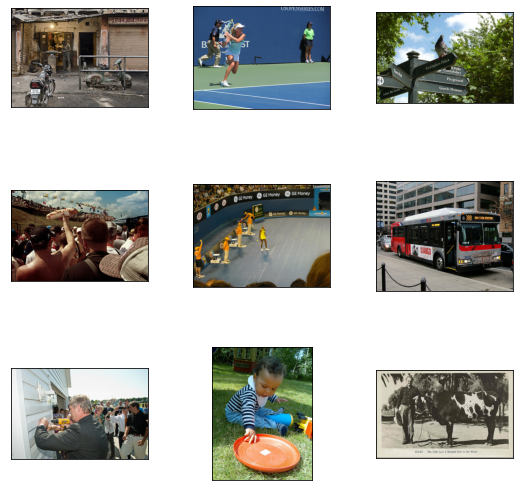

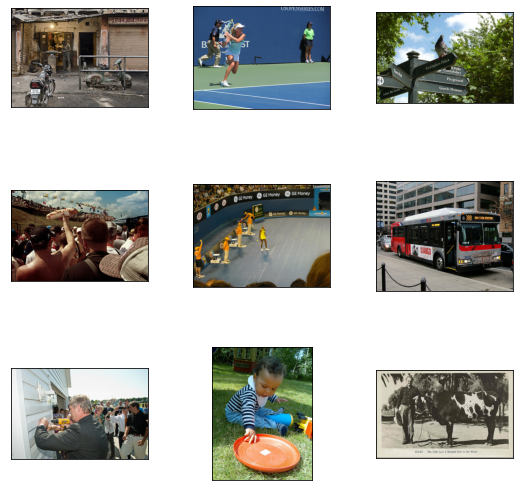

In [ ]:
tfds.show_examples(train_dataset, dataset_info)

# Visualization Coco Dataset

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


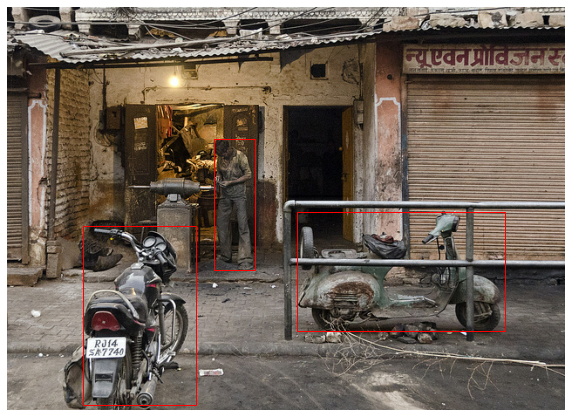

In [ ]:
data = next(iter(train_dataset))
image = np.array(data['image'], dtype=np.uint8)
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(image)
bboxes = data['objects']['bbox']
image_height = image.shape[0]
image_width = image.shape[1]
bboxes = tf.stack([
    bboxes[:,0] * image_height,
    bboxes[:,1] * image_width,
    bboxes[:,2] * image_height,
    bboxes[:,3] * image_width,
], axis=-1)
for bbox in bboxes:
    ymin, xmin = bbox[:2]
    h, w = bbox[2:] - bbox[:2]
    rect = plt.Rectangle((xmin, ymin), w, h , fill=False, color='red')
    plt.axes().add_patch(rect)
plt.show()

# Define util function
- swap_xy : swap [ymin, xmin, ymax, xmax] ---> [xmin, ymin, xmax, ymax]
- convert_to_xywh : convert [xmin, ymin, xmax, ymax] ---> [x, y, w, h]
- convert_to_corners : convert [x, y, w, h] ---> [xmin, ymin, xmax, ymax]
- resize_and_pad_image : Functions to resize images
- random_flip_horizontal : Flip image with a 50 percentage
- preprocess_data : Preprocessing Coco datasets

In [ ]:
def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)

In [ ]:
def convert_to_xywh(boxes):
    return tf.concat([(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],axis=-1)

In [ ]:
def convert_to_corners(boxes):
    return tf.concat([boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],axis=-1)

In [ ]:
def resize_and_pad_image(image, min_side=800.0, max_side=1333.0, stride=128.0):
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)    
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
      ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio

In [ ]:
def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
          [1 - boxes[: , 2], boxes[: , 1], 1 - boxes[: , 0], boxes[:, 3]], axis=-1
        )
    return image, boxes

In [ ]:
def preprocess_data(sample):
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["label"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [bbox[:, 0] * image_shape[1],
         bbox[:, 1] * image_shape[0],
         bbox[:, 2] * image_shape[1],
         bbox[:, 3] * image_shape[0]],
         axis=-1
    )
    bbox = convert_to_xywh(bbox)

    return image, bbox, class_id

# Define Anchorbox Class

In [ ]:
class AnchorBox:
    def __init__(self):        
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1] 
        )
        anchors = tf.concat([centers, dims], axis=-1) 
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

# Define Calculating Iou Function

In [ ]:
def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.maximum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(rd - lu, 0.0)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8)
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

# Define Label Encoder Class

In [ ]:
class LabelEncoder:
    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4):        
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
             (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
             tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:])
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):        
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):       
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
          label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
          labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()

# Load Train Dataset & Validation Dataset

In [ ]:
label_encoder = LabelEncoder()
autotune = tf.data.AUTOTUNE

train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(batch_size * 8)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)

val_dataset = val_dataset.apply(tf.data.experimental.ignore_errors())
val_dataset = val_dataset.prefetch(autotune)

# Load Pretrained ResNet50 as backbone

In [ ]:
backbone = tf.keras.applications.ResNet50(include_top=False, input_shape=[224, 224, 3])

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
def get_backbone():    
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
      backbone.get_layer(layer_name).output
      for layer_name in ['conv3_block4_out', 'conv4_block6_out', 'conv5_block3_out']
    ]    
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

# Define FPN Class

In [ ]:
class FeaturePyramid(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.backbone = get_backbone()
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))        
        return p3_output, p4_output, p5_output, p6_output, p7_output

# Define build head function

In [ ]:
def build_head(output_filters, bias_init):
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    
    for _ in range(4):
      head.add(
          tf.keras.layers.Conv2D(256, 3, padding='same', kernel_initializer=kernel_init)
      )
      head.add(tf.keras.layers.ReLU())
    
    head.add(
        tf.keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

# Define RetinaNet Class

In [ ]:
class RetinaNet(tf.keras.Model):
    def __init__(self, num_classes, **kwargs):
        super().__init__()
        self.fpn = FeaturePyramid()
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
          box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
          cls_outputs.append(
              tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
          )

        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

# Define RetinaNet Loss

In [ ]:
class RetinaNetBoxLoss(tf.losses.Loss):
    def __init__(self, delta):
        super().__init__()
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5
        )
        return tf.reduce_sum(loss, axis=-1)

class RetinaNetClassificationLoss(tf.losses.Loss):
    def __init__(self, alpha, gamma):
        super().__init__()
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)

In [ ]:
class RetinaNetLoss(tf.losses.Loss):
    def __init__(self, num_classes=80, alpha=0.25, gamma=2.0, delta=1.0):
        super().__init__()
        self._cls_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)

        cls_loss = self._cls_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        cls_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, cls_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        cls_loss = tf.math.divide_no_nan(tf.reduce_sum(cls_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        
        loss = cls_loss + box_loss
        return loss

# Load Model & Loss & Optimizer

In [ ]:
model = RetinaNet(n_classes)
loss_fn = RetinaNetLoss()

# lr 0.01 was unstable so lowered the learning rate
optimizer = tf.optimizers.SGD(learning_rate=0.0001, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer)

# Set Callback List

In [ ]:
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=1,
    )
]

# Training
- The hardware performance was not good, so only proceeded with 1 epoch.

In [ ]:
epochs = 1

model.fit(
    train_dataset.take(100),
    validation_data=val_dataset.take(50),
    epochs=epochs,
    callbacks=callbacks_list,
    verbose=1,
)

    100/Unknown - 58s 499ms/step - loss: 240.4923
Epoch 1: saving model to ./retinanet/weights_epoch_1
100/100 [==============================] - 73s 645ms/step - loss: 240.4923 - val_loss: 244.7505
